In [11]:
# The goal of this project is too 

In [40]:
!pip install pandas

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [266]:
df_230019 = pd.read_csv("230019.csv")
df_249443 = pd.read_csv("249443.csv")
df_249445 = pd.read_csv("249445.csv")
df_290694 = pd.read_csv("290694.csv")
df_297697 = pd.read_csv("297697.csv")

,time_stamp,sensor_index,corr_pm2.5_a,pm2.5_cf_1_a,corr_pm2.5_b,pm2.5_cf_1_b,pm_cf1,humidity_a,humidity_b,temperature_a,temperature_b
0,2025-11-01 00:01:00,230019,7.5320,13.6,8.1608,14.8,7.8464,62,62,53,53
1,2025-11-01 00:03:00,230019,7.0942,12.6,7.0418,12.5,7.0680,61,61,53,53
2,2025-11-01 00:05:00,230019,7.0418,12.5,7.8278,14.0,7.4348,61,61,53,53
3,2025-11-01 00:07:00,230019,7.2328,12.7,7.5996,13.4,7.4162,60,60,52,52
4,2025-11-01 00:09:00,230019,7.0232,12.3,6.7612,11.8,6.8922,60,60,52,52
...,...,...,...,...,...,...,...,...,...,...,...
20553,2025-11-29 23:50:00,230019,1.0970,2.8,1.4114,3.4,1.2542,71,71,41,41
20554,2025-11-29 23:52:00,230019,1.2018,3.0,1.3066,3.2,1.2542,71,71,41,41
20555,2025-11-29 23:54:00,230019,1.3590,3.3,1.8830,4.3,1.6210,71,71,41,41
20556,2025-11-29 23:56:00,230019,1.7072,3.8,1.9692,4.3,1.8382,70,70,41,41


In [143]:
def clean_sensor(df, sensor_id):
    df = df.copy()
    
    # chronological
    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
    df = df.sort_values('time_stamp')
    
    # average humidity & temperature
    df['humidity'] = df[['humidity_a', 'humidity_b']].mean(axis=1)
    df['temperature'] = df[['temperature_a', 'temperature_b']].mean(axis=1)

    # set new variables
    df = df[['time_stamp', 'pm_cf1', 'humidity', 'temperature']]
    df = df.rename(columns={'time_stamp': 'timestamp', 'pm_cf1': 'pm25'})

    # remove invalid 
    df = df[df['pm25'] >= 0]
    df = df[(df['humidity'] >= 0) & (df['humidity'] <= 100)]
    df = df.dropna()

    # hourly aggregation
    df = df.set_index('timestamp').resample('1h').mean()

    df['sensor_id'] = sensor_id
    return df.reset_index()

In [268]:
clean_230019 = clean_sensor(df_230019, '230019')
clean_249443 = clean_sensor(df_249443, '249443')
clean_290694 = clean_sensor(df_290694, '290694')
clean_249445 = clean_sensor(df_249445, '249445')
clean_297697 = clean_sensor(df_297697, '297697')

,timestamp,pm25,humidity,temperature,sensor_id
0,2025-11-01 00:00:00,6.596787,59.800000,52.500000,230019
1,2025-11-01 01:00:00,6.031787,58.300000,52.233333,230019
2,2025-11-01 02:00:00,5.786380,58.300000,52.033333,230019
3,2025-11-01 03:00:00,6.268827,58.366667,52.033333,230019
4,2025-11-01 04:00:00,6.094147,56.300000,52.033333,230019
...,...,...,...,...,...
691,2025-11-29 19:00:00,7.025847,68.500000,37.533333,230019
692,2025-11-29 20:00:00,6.748153,68.266667,37.500000,230019
693,2025-11-29 21:00:00,5.611833,68.166667,38.533333,230019
694,2025-11-29 22:00:00,4.491324,68.137931,39.689655,230019


In [216]:
all_clean = pd.concat([clean_230019, clean_249443, clean_249445, clean_290694, clean_297697], ignore_index=True)

common_start = all_clean.groupby('sensor_id')['timestamp'].min().max()
common_end   = all_clean.groupby('sensor_id')['timestamp'].max().min()

all_common = all_clean[(all_clean['timestamp'] >= common_start) & (all_clean['timestamp'] <= common_end)]

<Axes: title={'center': 'PM2.5 (Hourly) by Sensor'}, xlabel='timestamp'>

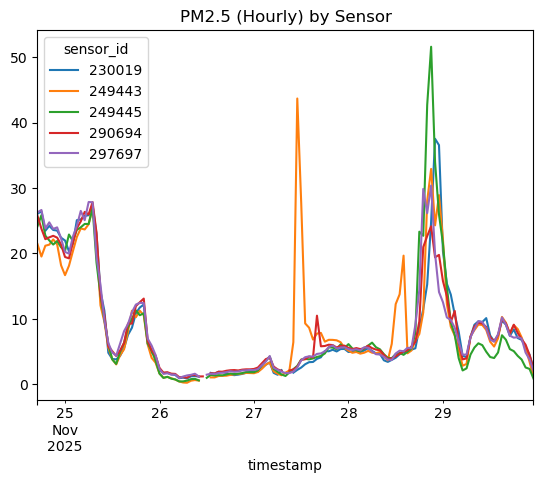

In [236]:
pivot_pm25 = all_common.pivot(index='timestamp', columns='sensor_id', values='pm25')
pivot_pm25.plot(title="PM2.5 (Hourly) by Sensor")

<Axes: title={'center': 'Sensor Variability Over Time'}, xlabel='timestamp', ylabel='Standard deviation (µg/m³)'>

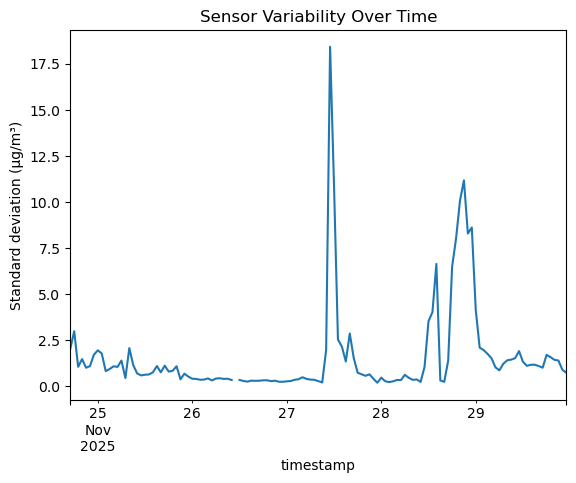

In [240]:
pm25_std = pivot_pm25.std(axis=1)

pm25_std.plot(title="Sensor Variability Over Time", ylabel="Standard deviation (µg/m³)")

Text(0, 0.5, 'z-score')

<Figure size 640x480 with 0 Axes>

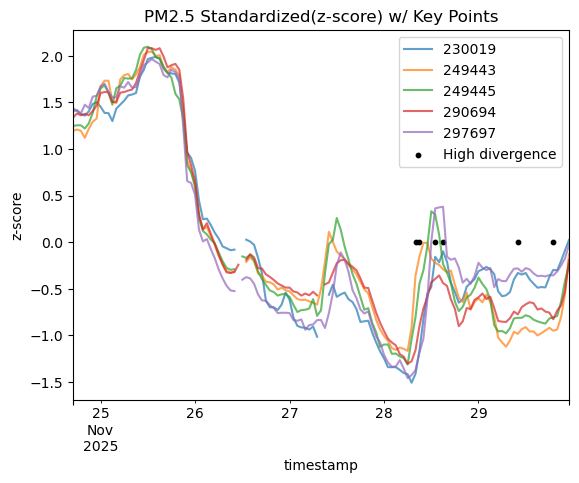

In [250]:
high_var = pm_std > pm_std.quantile(0.9544)

z_score = lambda s: (s - s.mean()) / s.std()
plt.figure()
pivot_pm.apply(z_score).plot(alpha=0.7)

plt.scatter(
    pm_std[high_var].index,
    [0] * high_var.sum(),
    color='black',
    s=10,
    label='High divergence'
)

plt.legend()
plt.title("PM2.5 Standardized(z-score) w/ Key Points")
plt.xlabel("timestamp")
plt.ylabel("z-score")

In [258]:
# community mean at each timestamp
pm_mean = pivot_pm.mean(axis=1)

# deviation of each sensor from community mean
deviation = pivot_pm.subtract(pm_mean, axis=0)

high_var_times = deviation.loc[high_var]

max_dev_value = high_var_times.apply(
    lambda row: row[row.abs().idxmax()],
    axis=1
)
summary_lines = []

for t in high_var_times.index:
    sensor = max_dev_sensor.loc[t]
    value = max_dev_value.loc[t]

    direction = "above" if value > 0 else "below"

    summary_lines.append(
        f"At {t}, Sensor {sensor} deviated most from the community average "
        f"({abs(value):.2f} µg/m³ {direction} the mean)."
    )

for line in summary_lines[:10]:
    print(line)

At 2025-11-28 08:00:00, Sensor 249443 deviated most from the community average (5.31 µg/m³ above the mean).
At 2025-11-28 09:00:00, Sensor 249443 deviated most from the community average (4.81 µg/m³ above the mean).
At 2025-11-28 13:00:00, Sensor 297697 deviated most from the community average (4.74 µg/m³ above the mean).
At 2025-11-28 15:00:00, Sensor 297697 deviated most from the community average (5.99 µg/m³ above the mean).
At 2025-11-29 10:00:00, Sensor 297697 deviated most from the community average (4.53 µg/m³ above the mean).
At 2025-11-29 19:00:00, Sensor 297697 deviated most from the community average (3.93 µg/m³ above the mean).
